# 14. 어제 오른 내 주식, 과연 내일은?

오늘은 시계열 예측(Time-Series Prediction)을 다루는 여러 가지 통계적 기법 중에 가장 널리 알려진 ARIMA(Auto-regressive Integrated Moving Average)에 대해 알아보고 이를 토대로 특정 주식 종목의 가격을 예측해 보는 실습을 진행해 보려고 합니다.

시계열 예측에 사용되는 모델에 ARIMA만 있는 것은 아닙니다. 페이스북에서 발표한 Prophet이라는 것도 있고, LSTM 등 딥러닝을 활용하는 방법도 있습니다. 하지만 ARIMA는 탄탄한 통계학 이론적 기반을 갖추고 있으며, 시계열 데이터를 이해하는 관점을 훈련하는 데에도 도움이 된다는 점에서 한 번쯤 다루어 볼 만한 주제라고 여겨집니다.



#### 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.


실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.


## STEP 1 : 시계열 데이터 준비 (APPL)

Data = 미국주식 대장주중 하나인 Apple.inc를 스티브잡스 10주년을 기리며 분석해보겠다. (여기서 한번 애도의 묵념을 취해준다)

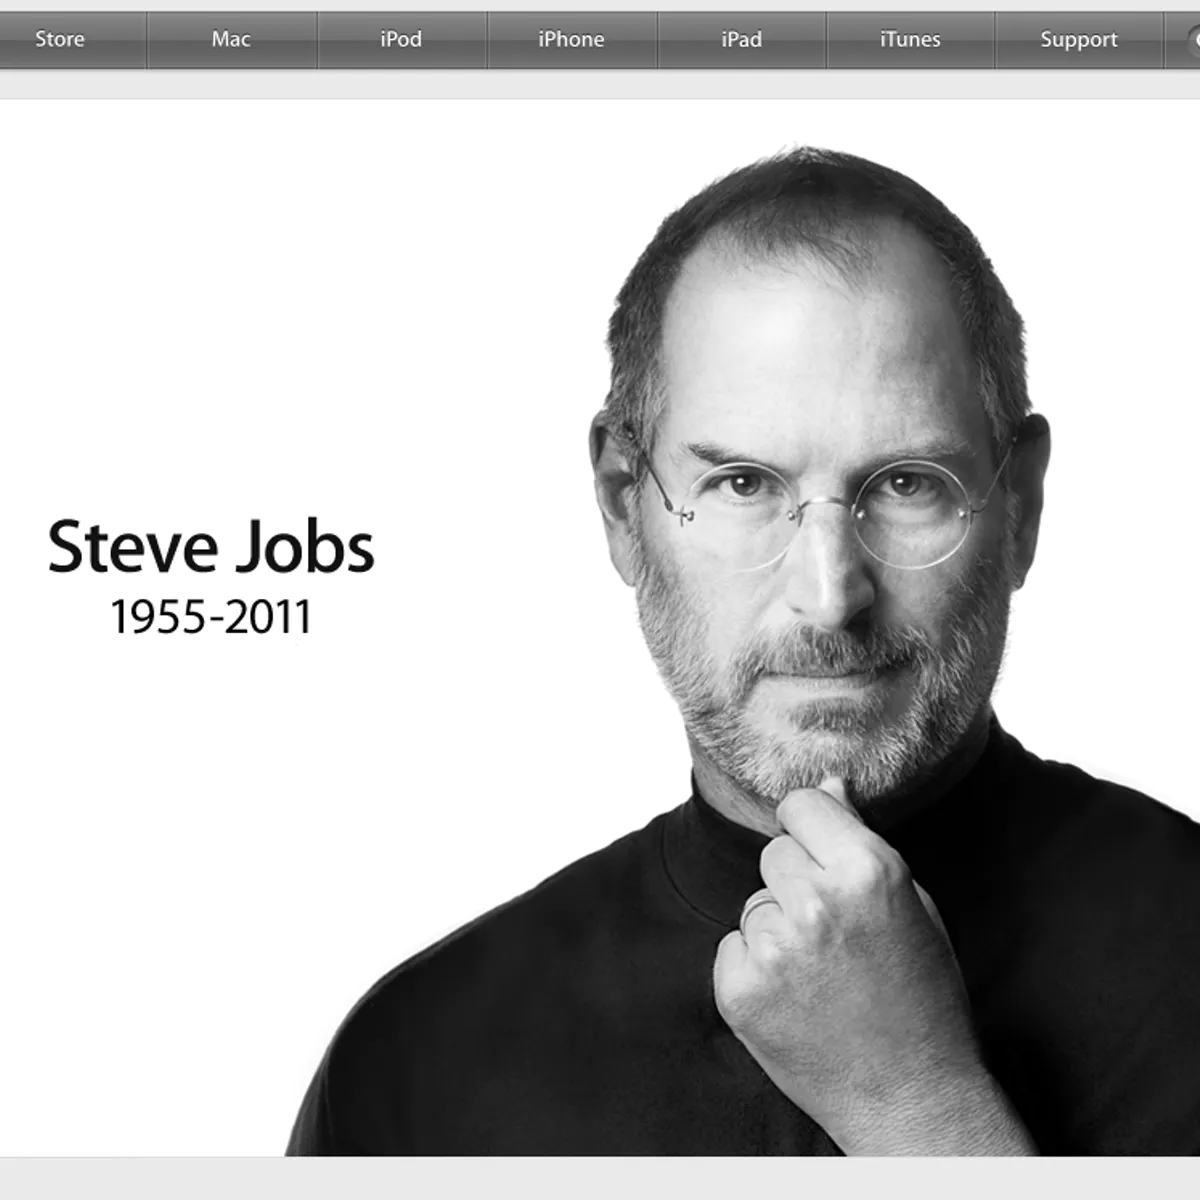




 - 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume

 - 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
 
 - 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

 - **날짜를 2005년부터 준비! (from 2005/01/01)**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math





rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6로 지정해 줍니다.


dataset_filepath = os.getenv('HOME') + '/aiffel/EXP_14_stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

# 이번에는 Close 가격만을 사용하여 시계열 분석을 진행하고자 함
AAPL = df['Close']


# from 1980
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.156786,1.162679,1.117857,1.130179,0.968976,691992000
2005-01-04,1.139107,1.169107,1.124464,1.141786,0.978927,1096810400
2005-01-05,1.151071,1.165179,1.143750,1.151786,0.987501,680433600
2005-01-06,1.154821,1.159107,1.130893,1.152679,0.988266,705555200
2005-01-07,1.160714,1.243393,1.156250,1.236607,1.060223,2227450400


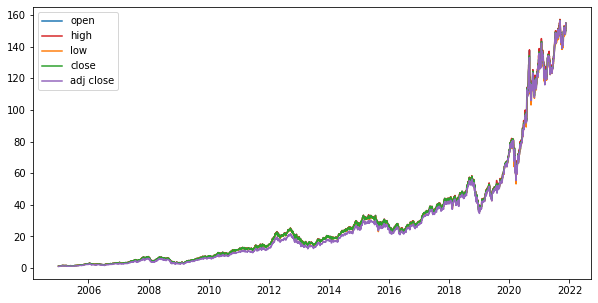

In [2]:
# graph to see total variables

rcParams['figure.figsize'] = 10, 5
plt.plot(df['Open'], color = 'tab:blue', label = 'open')
plt.plot(df['High'], color = 'tab:red', label = 'high')
plt.plot(df['Low'], color = 'tab:orange', label = 'low')
plt.plot(df['Close'], color = 'tab:green', label = 'close')
plt.plot(df['Adj Close'], color = 'tab:purple', label = 'adj close')
plt.legend(loc = 'best')
plt.show()

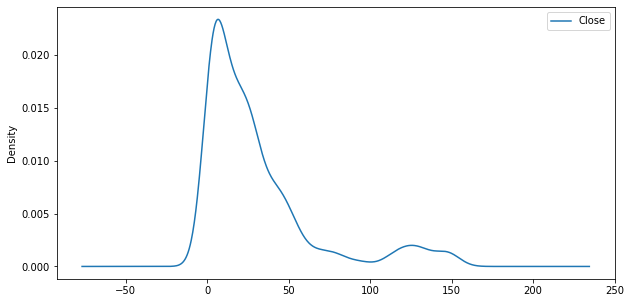

In [3]:
# kde plot | close 가격 확률밀도 함수 확인
df['Close'].plot(kind = 'kde')
plt.legend(loc = 'best')
plt.show()

####  눈대중으로 Stationary 정도 확인

In [20]:
def plot_rolling_data(data, window = 5):
    rollmean = data.rolling(window = window).mean()
    rollstd = data.rolling(window = window).std()
    print(rollstd.count())
    # 구간별 평균, 표준편차, original 값 확인하기 위해 plotting
    orig = plt.plot(data, color = 'tab:blue', label = 'orig')
    avg = plt.plot(rollmean, color = 'tab:green', label = 'avg')
    std = plt.plot(rollstd, color = 'tab:orange', label = 'std')
    plt.legend(loc = 'best')
    plt.title('Rolling Stock Close Price_Orig, Avg, Std')
    plt.show()

4247


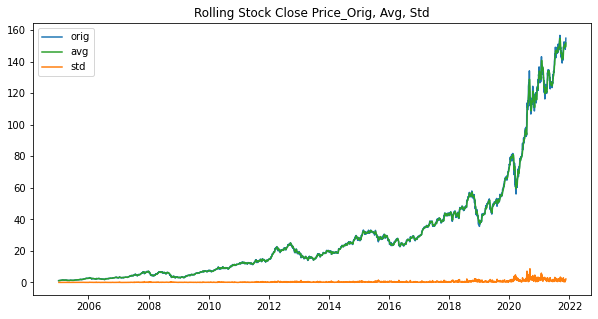

In [22]:
# window = 5, timeslot 5일
# timeslot 1224개

plot_rolling_data(AAPL, window = 5)

206


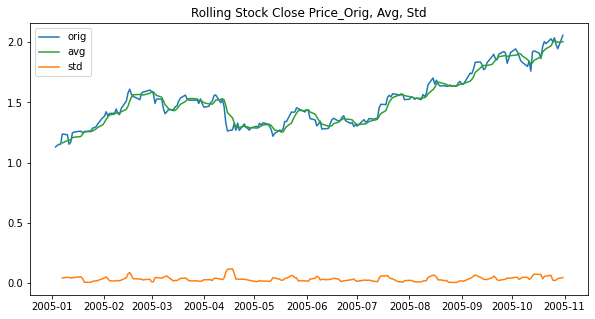

In [24]:
plot_rolling_data(AAPL[:210], window = 5)

window를 5로 한 것이 문제인 것 같음. 너무 짧은 rolling 구간인 듯 싶음

window를 20(4weeks), 60(3months), 120(6months) 기준으로 진행하고자 함

4232


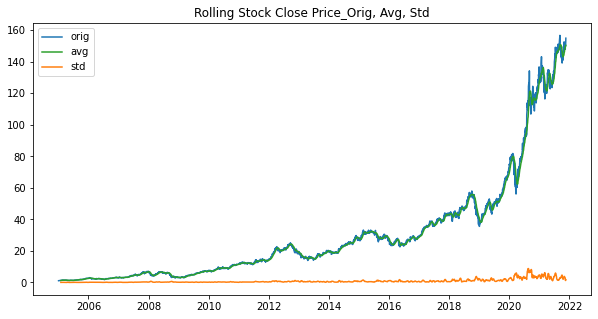

In [26]:
# window = 20days (4주)
# timeslot 1209개 
plot_rolling_data(AAPL, window = 20)

4192


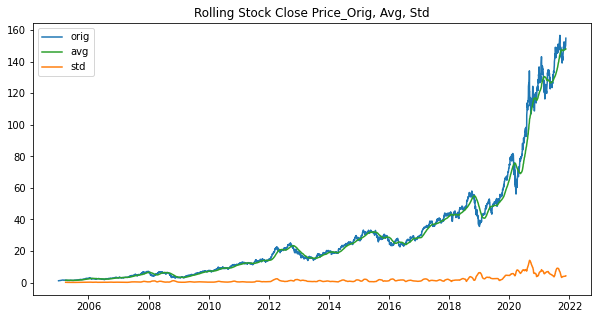

In [27]:
# window = 60 3개월(분기)
# timeslot 1169개 
plot_rolling_data(AAPL, window = 60)

4132


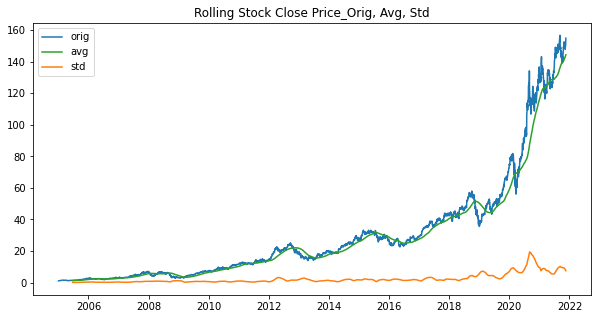

In [28]:
# window = 120 6개월(반기)
# 이렇게 되면 총 timeslot이 
plot_rolling_data(AAPL, window = 120)

#### 2-2. 통계적 방법으로 Stationary 정도 확인
Augmented Dickey-Fuller Test(ADF) 사용

In [37]:
def augmented_dickey_fuller(data):
    adfuller_test = adfuller(data, autolag = 'AIC')

    adfuller_test_output = pd.Series(adfuller_test[:4], 
                            index = ['test_statistic', 'pvalue', 'num_of_lags', 'num_of_observation'])
    for key, value in adfuller_test[4].items():
        adfuller_test_output['critical_values (%s)' %key] = value
    print(adfuller_test_output)

Fuction 하나 더 생성

뒤에서 adfuller test의 결과 p-value 및 num of lags가 0이 나와서
추가적으로 autolag 변수 변경하여 생성
AIC는 최소 lag 찾고, t-stat은 최대 lag 찾음

In [38]:
def augmented_dickey_fuller_2(data):
    adfuller_test = adfuller(data, autolag = 't-stat')

    adfuller_test_output = pd.Series(adfuller_test[:4], 
                            index = ['test_statistic', 'pvalue', 'num_of_lags', 'num_of_observation'])
    for key, value in adfuller_test[4].items():
        adfuller_test_output['critical_values (%s)' %key] = value
    print(adfuller_test_output)

In [39]:
augmented_dickey_fuller(AAPL)

test_statistic              3.475182
pvalue                      1.000000
num_of_lags                30.000000
num_of_observation       4220.000000
critical_values (1%)       -3.431901
critical_values (5%)       -2.862225
critical_values (10%)      -2.567135
dtype: float64


## STEP 2 : 각종 전처리 수행

 - 결측치 처리
 - 로그 변환

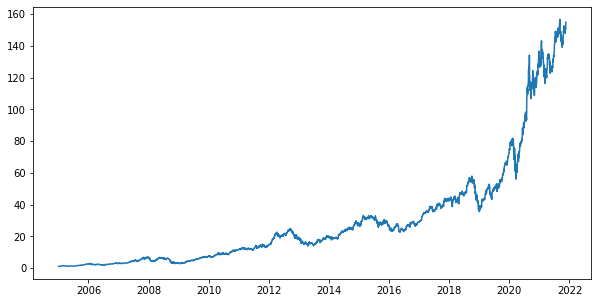

In [4]:
# 그래프 확인


# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(AAPL)

In [5]:
# 결측치 처리
AAPL=AAPL.interpolate(method='time')
AAPL[AAPL.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

Series([], Name: Close, dtype: float64)

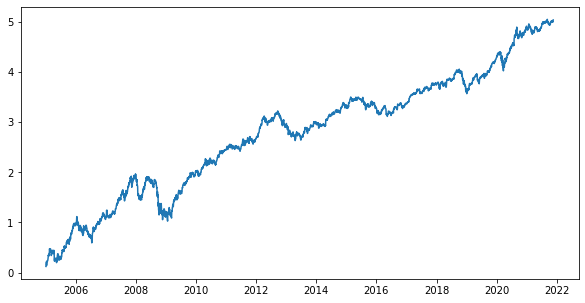

In [6]:
# 로그 변환 시도 후 다시 그래프 확인
AAPL_log = np.log(AAPL)
plt.plot(AAPL_log)

## STEP 3 : 시계열 안정성 분석

정성적 그래프 분석
정량적 Augmented Dicky-Fuller Test
시계열 분해(Time Series Decomposition)
Residual 안정성 확인

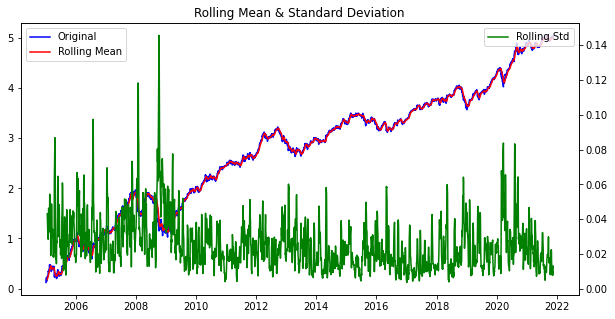

In [7]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
     # 축을 2개를 사용해서 눈에 잘 보이게 해줌
    ax1 = plt.subplot(111)
    ax2 = ax1.twinx()
    orig, = ax1.plot(timeseries, color='blue',label='Original')    
    mean, = ax1.plot(rolmean, color='red', label='Rolling Mean')
    std, = ax2.plot(rolstd, color='green', label='Rolling Std')
    label = [orig, mean]
    ax1.legend(label, [i.get_label() for i in label], loc=2)
    ax2.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(AAPL_log, window=12) # timestep은 1년으로

In [8]:
#정량적 Augmented Dicky-Fuller Test

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(AAPL) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                    3.475182
p-value                           1.000000
#Lags Used                       30.000000
Number of Observations Used    4220.000000
Critical Value (1%)              -3.431901
Critical Value (5%)              -2.862225
Critical Value (10%)             -2.567135
dtype: float64


In [9]:
augmented_dickey_fuller_test(AAPL_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.940701
p-value                           0.774274
#Lags Used                       16.000000
Number of Observations Used    4234.000000
Critical Value (1%)              -3.431895
Critical Value (5%)              -2.862223
Critical Value (10%)             -2.567134
dtype: float64


 - p값이 좀 줄어들기는 했지만 여전히 귀무가설을 기각 할 수 있는 수준은 아니다.

 - 차분이 필요하므로 d는 1 이상의 값이 나올것이다.

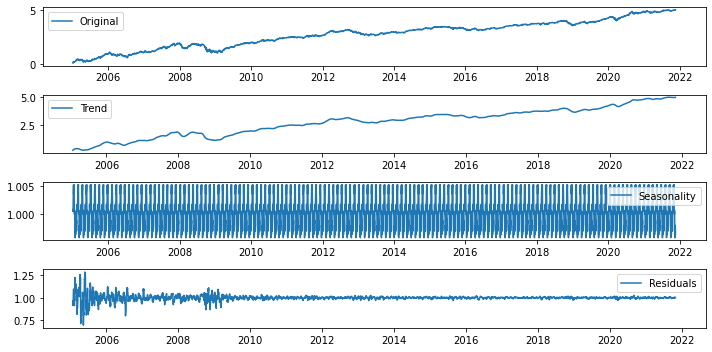

In [11]:
#시계열 분해 (Time Series Decomposition)
# model: 주기적 변화의 크기나 전체적인 level의 variation이 일정할 때에는 additive
# model: 시간의 흐름에 비례하게 변화한다면 multiplicative
# 경제 지표 관련 타임시리즈는 multiplicative model을 따르는 경우가 많다
# https://yoongaemii.github.io/seasonal_decomposition

decomposition = seasonal_decompose(AAPL_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(AAPL_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [12]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -21.636816
p-value                           0.000000
#Lags Used                       22.000000
Number of Observations Used    4198.000000
Critical Value (1%)              -3.431909
Critical Value (5%)              -2.862229
Critical Value (10%)             -2.567137
dtype: float64


4102


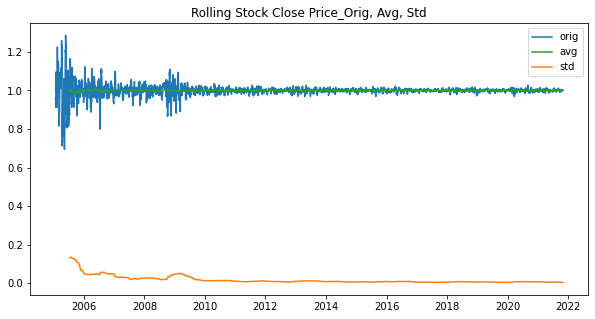

In [29]:
plt.rcParams['figure.figsize'] = 10, 5

# plot_rolling_data(residual, window = 60)
plot_rolling_data(residual, window = 120)

위의 그래프로 보아 AAPL 주식 데이터는 Trend와 Seasonality가 확실히 도드라지는 데이터라 생각됨


이제부터는 AR 및 MA 특성을 한번에 파악할 수 있는 ARIMA Model을 이용해 진행할 예정이기 때문에 origin data -> ts_log를 사용하고자 함

## STEP 4 : 학습, 테스트 데이터셋 생성



1. AutoRegressive : p. 데이터가 평균으로 수렴하는 모델. Residual에 해당하는 부분


2. Moving Average : q. 오차값의 가중합으로 수렴하는 모델. Trend에 해당하는 부분


3. Integration : d. 이전 데이터 + 차분의 누적합으로 수렴하는 모델. Seasonality에 해당하는 부분


-> Parameter 설정을 위해 ACF, PACF, 차분을 사용하고자 함

#### 4-1. ACF & PACF | ARIMA parameter 설정
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt

ACF(AutoCorrelation Fuction)

MA의 시차 q를 결정
yt와 yt+k 의 corr 측정
즉, yt와 yt+k 두 시점의 차이를 가지는 자료가 얼마나 관계가 있는지 측정


PACF(Partial AutoCorrelation Function)

AR의 시차 p를 결정
yt와 yt+k 의 corr 측정시, 다른 y값들의 영향력을 배제하고 측정
순수하게 시점 간 상관만 추출한 것
큰 숫자로 시작해서 완만하게 떨어져야 positive한 관계 즉, 자기상관관계가 있다고 볼 수 있음


##### **최근 코로나시국으로 인한 급락과 급등을 반영하기 위해! 최근날짜 기준으로 5%만을 테스트로 사용!**

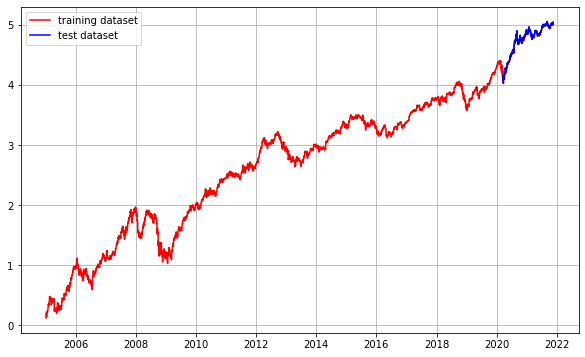

In [73]:

train, test = AAPL_log[:int(len(AAPL_log)*0.95)], AAPL_log[int(len(AAPL_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(AAPL_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

ACF, PACF 그려보기 -> p,q 구하기
차분 안정성 확인 -> d 구하기


AutoRegressive : p. 데이터가 평균으로 수렴하는 모델. Residual에 해당하는 부분


Moving Average : q. 오차값의 가중합으로 수렴하는 모델. Trend에 해당하는 부분


Integration : d. 이전 데이터 + 차분의 누적합으로 수렴하는 모델. Seasonality에 해당하는 부분


-> Parameter 설정을 위해 ACF, PACF, 차분을 사용하고자 함

#### 4-1. ACF & PACF | ARIMA parameter 설정
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.graphics.tsaplots as sgt

ACF(AutoCorrelation Fuction)

MA의 시차 q를 결정
yt와 yt+k 의 corr 측정
즉, yt와 yt+k 두 시점의 차이를 가지는 자료가 얼마나 관계가 있는지 측정


PACF(Partial AutoCorrelation Function)

AR의 시차 p를 결정
yt와 yt+k 의 corr 측정시, 다른 y값들의 영향력을 배제하고 측정
순수하게 시점 간 상관만 추출한 것
큰 숫자로 시작해서 완만하게 떨어져야 positive한 관계 즉, 자기상관관계가 있다고 볼 수 있음

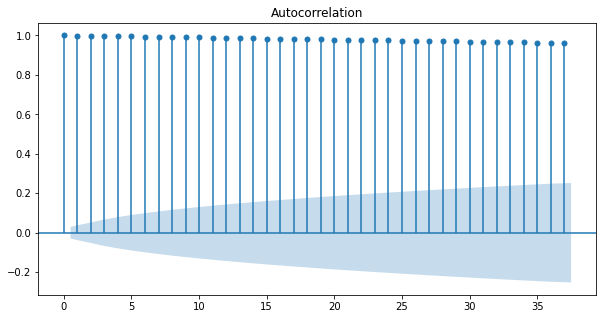

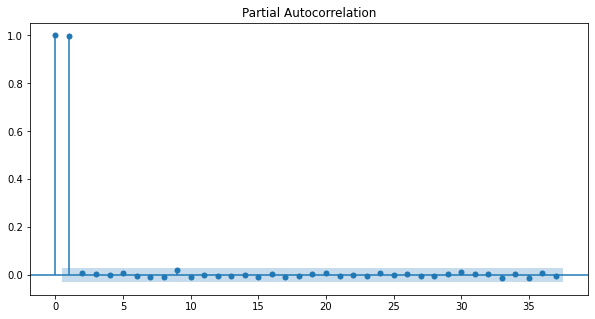

In [63]:
# ACF, PACF 그려보기

plot_acf(AAPL_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(AAPL_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

PACF 1의 Time lag에서 1에 가까운 값이 나오고 이후에 급격히 감소


다른 시차와 관련성이 없으므로 AR 모델의 시차는 p=1로 설정하면 될 것 같다


ACF 그래프는 아주 서서히 감소하고 있어서 q 값을 정할 수는 없다.


(1,0,0) 일단 시도!

#### 4-2. 차분으로 d 설정

#### 4.2.1. d=20

Results of Dickey-Fuller Test:
Test Statistic                -8.953644e+00
p-value                        8.589614e-15
#Lags Used                     3.000000e+01
Number of Observations Used    4.200000e+03
Critical Value (1%)           -3.431908e+00
Critical Value (5%)           -2.862228e+00
Critical Value (10%)          -2.567136e+00
dtype: float64


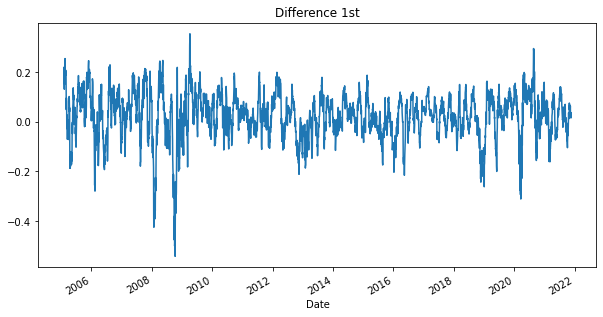

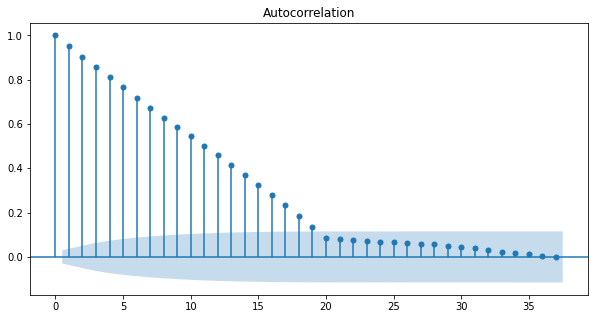

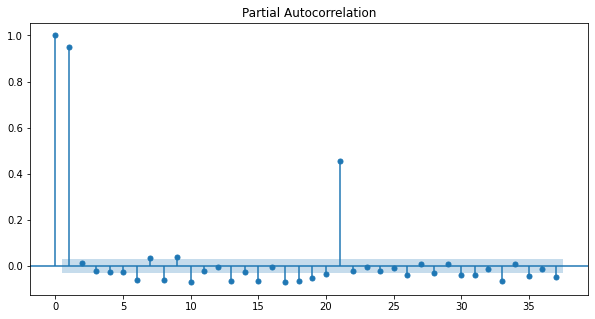

In [64]:
# 차분 안정성 확인

# 1차 차분 구하기 (20)
diff_1 = AAPL_log.diff(periods=20).iloc[20:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# ACF, PACF 다시 확인
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

#### 4-2-2. period = 1 세팅

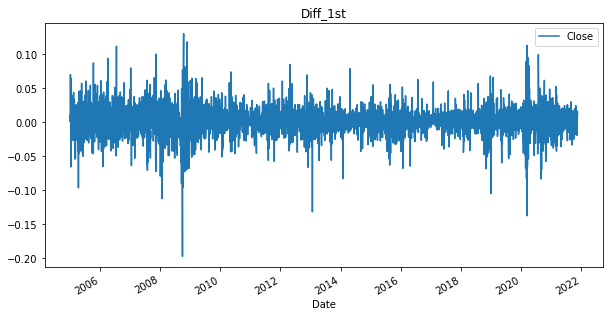

test_statistic          -1.517902e+01
pvalue                   6.235522e-28
num_of_lags              1.500000e+01
num_of_observation       4.234000e+03
critical_values (1%)    -3.431895e+00
critical_values (5%)    -2.862223e+00
critical_values (10%)   -2.567134e+00
dtype: float64


In [65]:
# period 기준으로 값을 비교함
# period 1일 때 num of lags가 0으로 나옴 
rcParams['figure.figsize'] = 10, 5
diff_12 = AAPL_log.diff(periods=1).iloc[1:]
diff_12.plot(title = 'Diff_1st')
plt.legend(loc = 'best')
plt.show()

augmented_dickey_fuller(d_12)

#### 4-3. Origin data 와 Difference1(1차 차분_p = 20) 비교하여 Plot

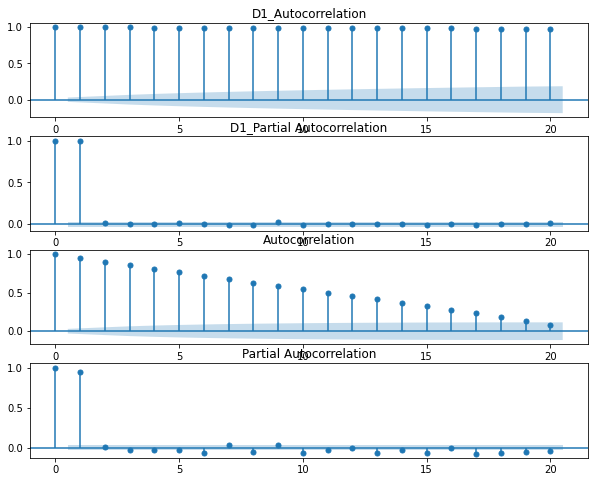

In [66]:
import statsmodels.graphics.tsaplots as sgt 

rcParams['figure.figsize'] = 10, 8
fig = plt.figure()
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

sgt.plot_acf(AAPL_log, lags = 20, ax = ax1) # 4주를 기준으로 시차 확인 
ax1.set_title('Origin_Autocorrelation')

sgt.plot_pacf(AAPL_log, lags = 20, ax = ax2)
ax2.set_title('Origin_Partial Autocorrelation')

sgt.plot_acf(diff_1, lags = 20, ax = ax3) # 4주를 기준으로 시차 확인 
ax1.set_title('D1_Autocorrelation')

sgt.plot_pacf(diff_1, lags = 20, ax = ax4)
ax2.set_title('D1_Partial Autocorrelation')
plt.show()

In [67]:
augmented_dickey_fuller_2(diff_1)

test_statistic          -8.953644e+00
pvalue                   8.589614e-15
num_of_lags              3.000000e+01
num_of_observation       4.200000e+03
critical_values (1%)    -3.431908e+00
critical_values (5%)    -2.862228e+00
critical_values (10%)   -2.567136e+00
dtype: float64


min lag 가 0일 때는 diff하면 pvalue까지 0이 나옴


우선 d = 1로 세팅한 뒤, 두개의 adfuller test 방법으로 진행해보기


즉, p = 1, q = 0, d = 1 으로 우선 세팅하여 ARIMA 진행

## 4-4. ARIMA MODEL Training

In [68]:
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# Model Build & fit
model = ARIMA(train, order =(1,1,0)) # p, d, q 순서 
fit_model = model.fit(trend='c',disp=-1) # disp = -1해도 동일한 값 나옴 
print(fit_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4037
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9860.364
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 18 Nov 2021   AIC                         -19714.727
Time:                        17:53:25   BIC                         -19695.818
Sample:                             1   HQIC                        -19708.027
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.000      3.640      0.000       0.001       0.002
ar.L1.D.Close    -0.0301      0.016     -1.911      0.056      -0.061       0.001
                                    Root

**AIC 값 낮게 나옴. 음수. AIC가 낮을수록 모델이 데이터에 더 적합해지고, 과적합을 방지함**

In [69]:
# predict 값 확인 
fit_model.predict()[:5]

Date
2005-01-04    0.001170
2005-01-05    0.000898
2005-01-06    0.000943
2005-01-07    0.001182
2005-01-10   -0.000908
dtype: float64

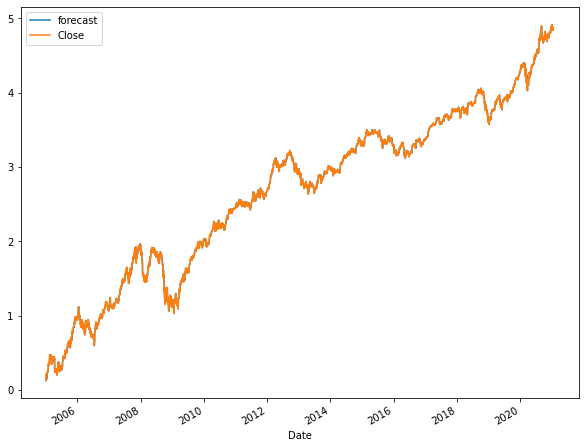

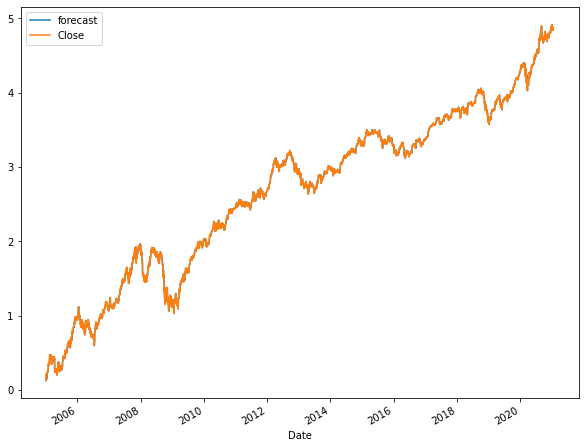

In [70]:
# predict 값 plot

fit_model.plot_predict()

**실제 데이터와 forecast한 값이 거의 온전히 유사한 모양을 보이고 있음**

## STEP 6 : ARIMA 모델 훈련과 테스트


 - ARIMA 모델 빌드와 훈련
 - 모델 테스트 및 플로팅
 - 최종 예측 모델 정확도 측정(MAPE)

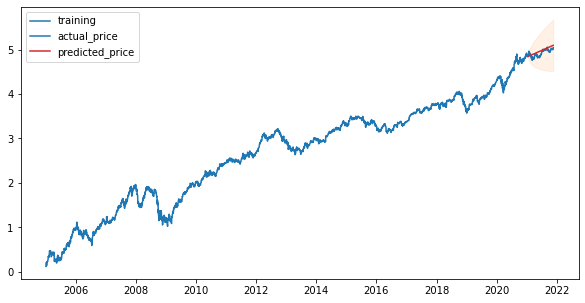

In [71]:
# 예측결과 : fc : .forecast의 첫번째 값 
# 예측결과의 하한 바운드 : se: .forecast의 첫번째 값 
# 예측결과의 상한 바운드 : conf: .forecast의 첫번째 값 

fc, se, conf = fit_model.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()

#### 4-3-2-2. 실데이터 Forecast 값 확인

log화 시킨 데이터이니 실제 값 확인하기 위해 exp화 시킴

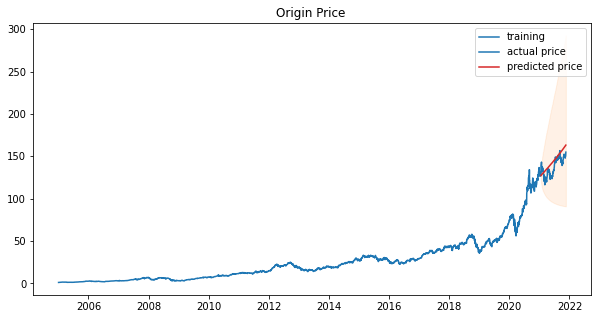

In [72]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train_exp, label = 'training')
plt.plot(test_exp, c = 'tab:blue', label = 'actual price')
plt.plot(fc_exp, c= 'tab:red', label = 'predicted price')
plt.fill_between(lower_exp.index, lower_exp, upper_exp, color = 'tab:orange', alpha = 0.10)
plt.title('Origin Price ')
plt.legend()
plt.show()

#### 4-2. ARIMA 모델 오차율 확인



In [74]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math 

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  98.79575276164454
MAE:  8.529263166997804
RMSE:  9.939605261862491
MAPE: 6.36%


**6.36%의 오차율을 보임**

**Auto_Arima 사용해서 다시 진행해보려 함
**

## 5. ARIMA Model 사용_ Method 2 | AUTO_ARIMA

In [75]:
# 코드 참고 홍러닝(아래url 첨부)
import itertools

p = d = q = range(0, 4)
pdq = list(itertools.product(p,d,q))
# seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]
pdq[:5]

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0)]

In [76]:
import warnings
warnings.filterwarnings('ignore')

best_aic = np.inf
best_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    try:
        tmp_mdl = ARIMA(train, order = param)
        res = tmp_mdl.fit()
        print('ARIMA{} = AIC: {}'.format(param, res.aic))
        if res.aic < best_aic:
            best_aic = res.aic
            best_pdq = param
            best_mdl= tmp_mdl
    except:
        continue

print('Best ARIMA{} model - AIC:{}'.format(best_pdq, best_aic))
    

ARIMA(0, 0, 0) = AIC: 12553.970806572957
ARIMA(0, 0, 1) = AIC: 7075.997461968176
ARIMA(0, 0, 2) = AIC: 2232.7058853949893
ARIMA(0, 0, 3) = AIC: -1728.1475493212147
ARIMA(0, 1, 0) = AIC: -19713.07582474986
ARIMA(0, 1, 1) = AIC: -19714.83872402124
ARIMA(0, 1, 2) = AIC: -19713.596934761164
ARIMA(0, 1, 3) = AIC: -19711.721558685826
ARIMA(0, 2, 0) = AIC: -16790.415024745882
ARIMA(0, 2, 1) = AIC: -19686.696249087814
ARIMA(0, 2, 2) = AIC: -19688.398069547606
ARIMA(0, 2, 3) = AIC: -19687.146186956026
ARIMA(1, 0, 0) = AIC: -19694.21502089789
ARIMA(1, 0, 1) = AIC: -19695.195716404432
ARIMA(1, 0, 2) = AIC: -19693.63895619668
ARIMA(1, 0, 3) = AIC: -19691.941859695864
ARIMA(1, 1, 0) = AIC: -19714.72731152194
ARIMA(1, 1, 1) = AIC: -19713.250771200495
ARIMA(1, 1, 2) = AIC: -19711.615491488552
ARIMA(1, 1, 3) = AIC: -19712.492548039034
ARIMA(1, 2, 0) = AIC: -17990.800181444345
ARIMA(1, 2, 1) = AIC: -19690.267224372106
ARIMA(1, 2, 2) = AIC: -19683.949242088755
ARIMA(1, 2, 3) = AIC: -19688.290597469302
A

코드 참고 페이지 (https://github.com/js8456/aiffel_project/blob/master/%5BE_14%5DTimeSeries_Stocks_2.ipynb)


**Best ARIMA parameter 2,1,3 사용**

In [77]:
# Model_fit
model_2 = ARIMA(train, order =(2,1,3)) # p, d, q 순서 
fit_model2 = model_2.fit() # disp = -1해도 동일한 값 나옴 
print(fit_model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4037
Model:                 ARIMA(2, 1, 3)   Log Likelihood                9866.455
Method:                       css-mle   S.D. of innovations              0.021
Date:                Thu, 18 Nov 2021   AIC                         -19718.911
Time:                        18:00:36   BIC                         -19674.788
Sample:                             1   HQIC                        -19703.278
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0012      0.000      3.636      0.000       0.001       0.002
ar.L1.D.Close     1.2324      0.002    512.638      0.000       1.228       1.237
ar.L2.D.Close    -0.9925      0.002   -4

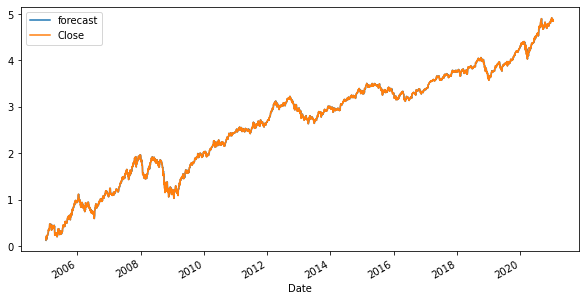

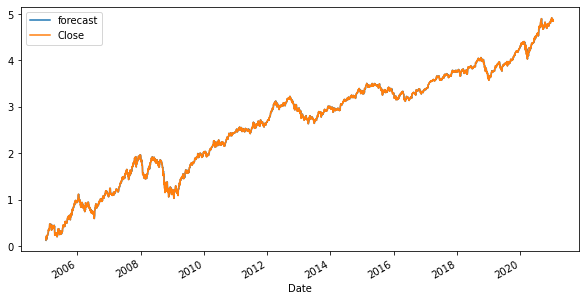

In [78]:
fit_model2.plot_predict()

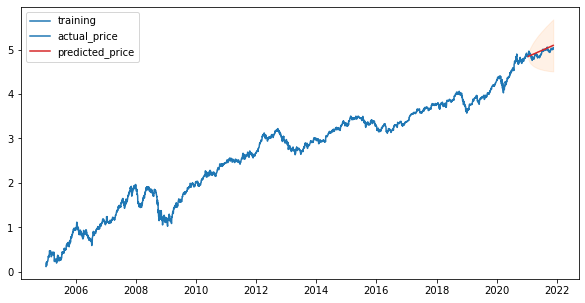

In [81]:
fc, se, conf = fit_model2.forecast(len(test), alpha = 0.05) # 95% conf

# pd 형태로 만들기 
fc = pd.Series(fc, index = test.index) 
lower = pd.Series(conf[:, 0], index = test.index)
upper = pd.Series(conf[:, 1], index = test.index) 

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train, label = 'training')
plt.plot(test, c = 'tab:blue', label = 'actual_price')
plt.plot(fc, c= 'tab:red', label = 'predicted_price')
plt.fill_between(lower.index, lower, upper, color = 'tab:orange', alpha = 0.10)
plt.legend()
plt.show()

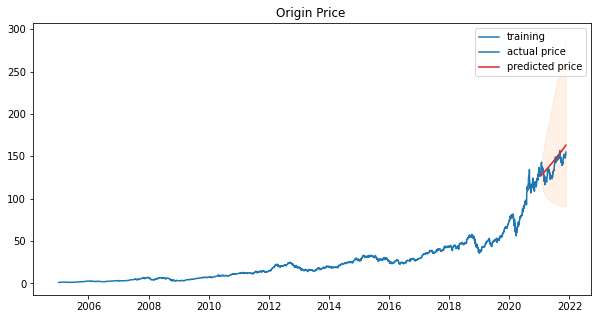

In [82]:
# log data 지수화 -> origin 범위로 만들기 
train_exp = np.exp(train)
test_exp = np.exp(test)
fc_exp = np.exp(fc)
lower_exp = np.exp(lower)
upper_exp = np.exp(upper)

# plot
rcParams['figure.figsize'] = 10,5
plt.plot(train_exp, label = 'training')
plt.plot(test_exp, c = 'tab:blue', label = 'actual price')
plt.plot(fc_exp, c= 'tab:red', label = 'predicted price')
plt.fill_between(lower_exp.index, lower_exp, upper_exp, color = 'tab:orange', alpha = 0.10)
plt.title('Origin Price ')
plt.legend()
plt.show()

In [85]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error
# import math 

mse = mean_squared_error(test_exp, fc_exp)
print('MSE: ', mse)

mae = mean_absolute_error(test_exp, fc_exp)
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(test_exp, fc_exp))
print('RMSE: ', rmse)

mape = np.mean(np.abs(fc_exp - test_exp)/np.abs(test_exp))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  96.64578393899906
MAE:  8.419174670267251
RMSE:  9.83085875897925
MAPE: 6.28%


**6.36%의 오차율에서 6.28%로 줄음**

MAPE(오차율)이 0.1% 정도 떨어짐, 많은 차이가 없으나 더 낮은 오차율을 보임


추가적으로 다른 기업의 주가 변동 또한 예측해보고자 함

# TESLA, NVIDIA, GOOGL, DOGE 의 주가 예측 진행


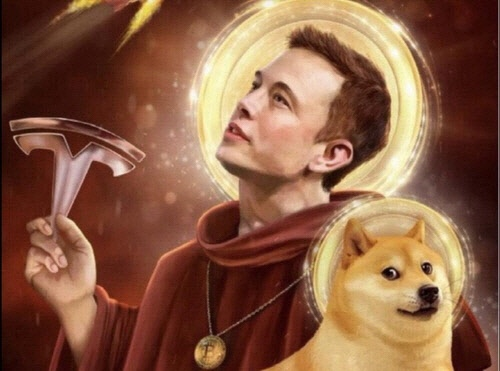
